In [1]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import os
import sys
sys.path.insert(0,'../python_scripts')
import numpy as np
from tqdm import tqdm_notebook as tq
import importlib
import meta
import utils
importlib.reload(utils)
from sklearn.manifold import Isomap
from time import time
import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


In [2]:
cropped_images = '../cropped_train/_gen/'

In [3]:
imgs_names = [{'d':dir,'imgs':os.listdir(cropped_images+dir)} for dir in os.listdir(cropped_images)]
print([img['d'] for img in imgs_names])

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [4]:
dictionary = meta.get_classes_dictionary()
reverse = meta.get_reverse_classes_dictionary()
reverse,dictionary

({'0': 'NoF',
  '1': 'OTHER',
  '2': 'ALB',
  '3': 'BET',
  '4': 'DOL',
  '5': 'LAG',
  '6': 'SHARK',
  '7': 'YFT'},
 {'ALB': 2,
  'BET': 3,
  'DOL': 4,
  'LAG': 5,
  'NoF': 0,
  'OTHER': 1,
  'SHARK': 6,
  'YFT': 7})

In [5]:
#imgs = np.array([[img_to_array(Image.open(img).resize((100,100))) for img in imgs] for imgs in imgs_names])
np.random.seed(42)
N = 200
imgs = np.array([[img_to_array((Image.open(cropped_images+imgs['d']+'/'+img).resize((80,80)).convert('L')))[0] for img in np.random.choice(imgs['imgs'],N)] for imgs in tq(imgs_names)])
tmp = {'0':'2','1':'3','2':'4','3':'5','4':'0','5':'1','6':'6','7':'7'}
labels = np.array([[utils.to_categorical(int(tmp[str(i)]),8) for img in np.random.choice(imgs['imgs'],N)] for i,imgs in tq(enumerate(imgs_names))])
labels = labels.reshape((8*N,8))
Label = np.array([[int(tmp[str(i)]) for img in np.random.choice(imgs['imgs'],N)] for i,imgs in tq(enumerate(imgs_names))])
Label = Label.reshape((N*8))

In [6]:
np.random.seed(1994)
N = 10
imgs_test = np.array([[img_to_array((Image.open(cropped_images+imgs['d']+'/'+img).resize((80,80)).convert('L')))[0] for img in np.random.choice(imgs['imgs'],N)] for imgs in tq(imgs_names)])
tmp = {'0':'2','1':'3','2':'4','3':'5','4':'0','5':'1','6':'6','7':'7'}
labels_test = np.array([[utils.to_categorical(int(tmp[str(i)]),8) for img in np.random.choice(imgs['imgs'],N)] for i,imgs in tq(enumerate(imgs_names))])
Label_test = np.array([[int(tmp[str(i)]) for img in np.random.choice(imgs['imgs'],N)] for i,imgs in tq(enumerate(imgs_names))])
Label_test = Label_test.reshape((N*8))

In [7]:
print(labels.shape,labels[0])

(1600, 8) [ 0.  0.  1.  0.  0.  0.  0.  0.]


In [37]:
#IMGS = np.array([img for img_l in imgs for img in img_l])
#IMGS_test = np.array([img for img_l in imgs_test for img in img_l])
Imgs_test = np.array([img.reshape(img.shape[0]*img.shape[1]) for img_l in imgs_test for img in img_l])
#print(IMGS.shape,len(IMGS))
#corr = np.dot(IMGS,IMGS.T).sum(axis=1).sum(axis=1)

In [38]:
Imgs = np.array([img.reshape(img.shape[0]*img.shape[1]) for img_l in imgs for img in img_l])
print(Imgs.shape)

(1600, 6400)


In [40]:
#corr.shape

In [11]:
##plt.imshow(corr)
#plt.show()

In [12]:
#for i in range(0,N*8,N):
#    plt.imshow(IMGS[i],cmap='gray')
#    plt.show()

In [13]:
n_components = 100
t0 = time()
pca = Isomap(n_components=n_components).fit(Imgs)
print("done in %0.3fs" % (time() - t0))

#eigenfaces = pca.components_.reshape((n_components, 100, 100))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = [pca.transform(img) for img in Imgs]
print("done in %0.3fs" % (time() - t0))

done in 35.036s
Projecting the input data on the eigenfaces orthonormal basis
done in 39.655s


In [14]:
X_train_pca = np.array(X_train_pca)
print(X_train_pca.shape)

(1600, 1, 100)


In [15]:
corr2 = np.dot(np.array(X_train_pca).mean(axis=1).T,np.array(X_train_pca).mean(axis=1))

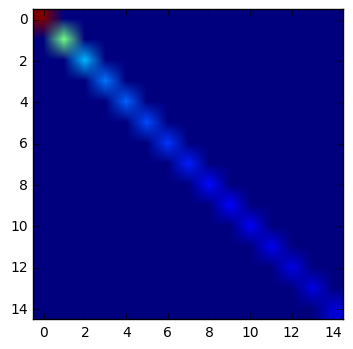

15


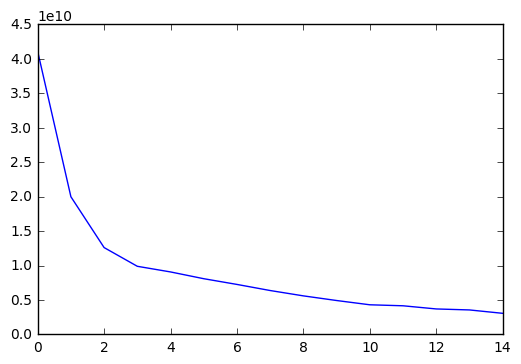

In [32]:
plt.imshow(corr2[:15,:15])
plt.show()
eigenvalues = []
B = 15
print(B)
for i in range(B):
    eigenvalues.append(corr2[i,i])
plt.plot(range(B),eigenvalues)
plt.show()

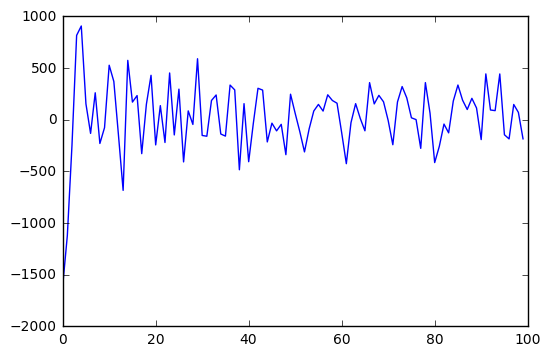

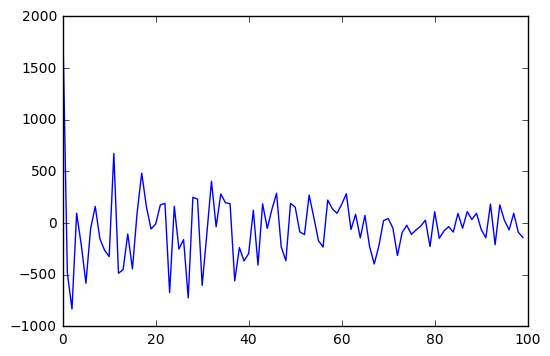

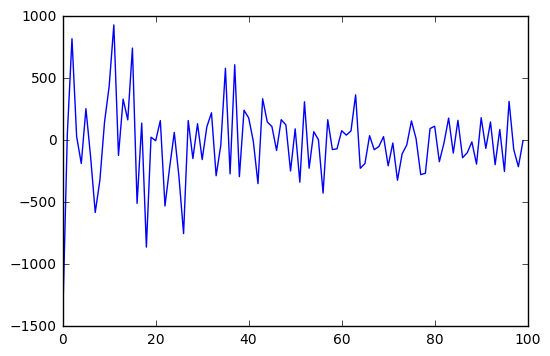

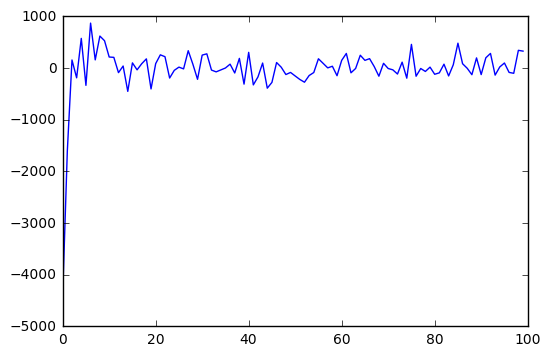

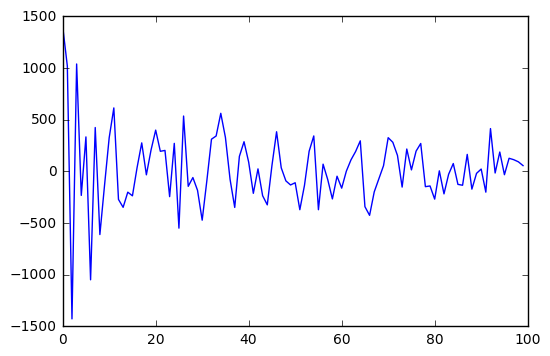

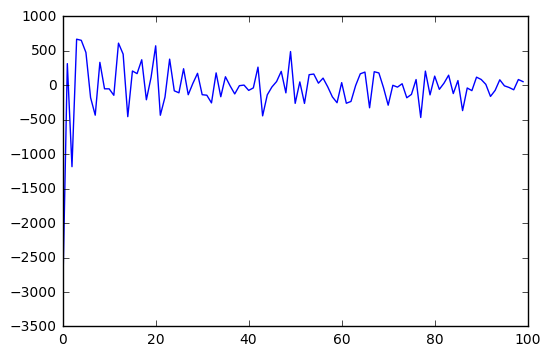

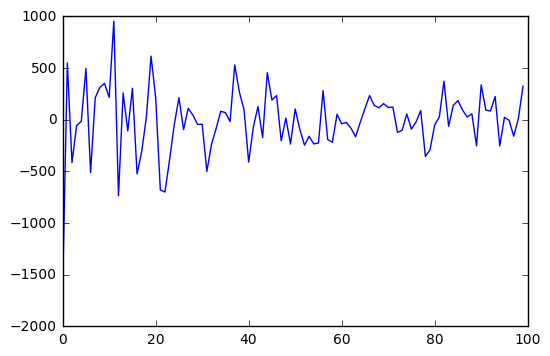

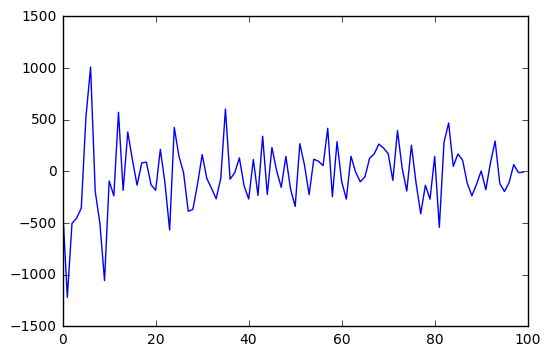

In [17]:
for i in range(0,8*N,N):
    obj = np.array(X_train_pca[i:i+N]).mean(axis=0).mean(axis=0)
    plt.plot(range(B),obj)
    plt.show()

In [18]:
from sklearn.externals import joblib
joblib.dump(pca, 'pca.pkl') 

['pca.pkl']

In [19]:
pca = joblib.load('pca.pkl')

In [59]:
results = []
for Z in tq(range(1,25)):
    X_train_pca = np.array(X_train_pca)

    X_pca = X_train_pca.mean(axis=1)#.reshape(X_train_pca.shape[0]*X_train_pca.shape[1])
    X_pca = X_pca[:,:Z]#.reshape(X_pca.shape[0]*X_pca.shape[1])
    l = Label
    #print(X_pca.shape,l.shape)
    #print("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(), param_grid)
    clf = clf.fit(X_pca, l)
    #print("done in %0.3fs" % (time() - t0))
    #print("Best estimator found by grid search:")
    #print(clf.best_estimator_)
    pca_test = np.array([pca.transform(img) for img in Imgs_test])
    PCA_test = pca_test.mean(axis=1)[:,:Z]#.reshape(X_train_pca.shape[0]*X_train_pca.shape[1])
    results.append(clf.score(PCA_test,Label_test))

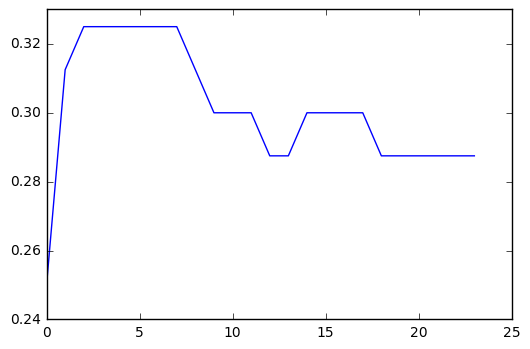

(array([2, 3, 4, 5, 6, 7], dtype=int64),)


In [63]:
plt.plot(range(24),results)
plt.show()
print(np.where(np.array(results)==np.array(results).max()))

### NEURAL NETWORK AFTER PCA 

In [24]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks
from keras.optimizers import *

remote = callbacks.RemoteMonitor(root='http://localhost:9000')
model = Sequential()
model.add(Dense(512, input_dim=(Z)))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(8,activation='softmax'))




In [25]:
sgd = SGD(lr=1, decay=1e-6, momentum=0.1, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

In [26]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           5632        dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 128)           65664       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 128)           0           dense_2[0][0]                    
___________________________________________________________________________________________

In [27]:
print(X_pca.shape, labels.shape)

(1600, 10) (1600, 8)


In [28]:
model.fit(X_pca, labels,batch_size=32,nb_epoch=100,callbacks=[remote],verbose=0)